In [ ]:
import pandas as pd
import numpy as np
import json
from googletrans import Translator  # pip install googletrans==4.0.0-rc1

# 1. Load the dataset
df = pd.read_csv("loan_details.csv")

# 2. Drop unnecessary columns
df.drop(columns=["created_at", "updated_at"], inplace=True, errors="ignore")

# 3. Fill missing values with NaN
df.replace(["", " ", "null", "None", None], np.nan, inplace=True)

# 4. Convert boolean-like columns to 1/0
bool_cols = [
    "is_providing_collateral",
    "is_interested_in_refinancing_existing_debt"
]
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().map({
            'true': 1, 't': 1, 'yes': 1, '1': 1,
            'false': 0, 'f': 0, 'no': 0, '0': 0
        }).fillna(np.nan)

# 5. Translate 'reason_for_acquisition' column to English
# 5. Translate 'reason_for_acquisition' column to English (fixed version)
if "reason_for_acquisition" in df.columns:
    from googletrans import Translator
    import asyncio

    translator = Translator()

    def translate_text(text):
        if pd.isna(text):
            return np.nan
        try:
            # if running inside async environment, run synchronously
            loop = asyncio.get_event_loop()
            if loop.is_running():
                # fallback for async notebooks
                return asyncio.run(translator.translate(str(text), dest='en')).text
            else:
                return translator.translate(str(text), dest='en').text
        except Exception:
            return text  # fallback to original if translation fails

    df["reason_for_acquisition_en"] = df["reason_for_acquisition"].apply(translate_text)
    df.drop(columns=["reason_for_acquisition"], inplace=True)


# 6. Expand JSON-like 'fund_uses' into separate columns
if "fund_uses" in df.columns:
    def parse_json_cell(cell):
        if pd.isna(cell):
            return {}
        try:
            parsed = json.loads(cell.replace("'", '"'))  # handle single quotes
            if isinstance(parsed, dict):
                return parsed
            elif isinstance(parsed, list):
                return {f"use_{i+1}": v for i, v in enumerate(parsed)}
            else:
                return {"use_1": parsed}
        except Exception:
            return {"use_1": cell}

    fund_expanded = df["fund_uses"].apply(parse_json_cell).apply(pd.Series)
    fund_expanded.columns = [f"fund_use_{i+1}" for i in range(len(fund_expanded.columns))]
    df = pd.concat([df.drop(columns=["fund_uses"]), fund_expanded], axis=1)

# 7. Save cleaned dataset
df.to_csv("loan_details_cleaned.csv", index=False)
print("✅ Cleaning complete! Saved as 'loan_details_cleaned.csv'.")


✅ Cleaning complete! Saved as 'loan_details_cleaned.csv'.


/tmp/ipython-input-94363782.py:47: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return text  # fallback to original if translation fails


In [ ]:
!pip install googletrans

In [ ]:
import pandas as pd
import numpy as np

# Load your cleaned dataset
df = pd.read_csv("loan_details_cleaned.csv")

# Columns containing 't'/'f' that need conversion
bool_text_cols = ["meta_status", "no_other_use_of_funds"]

# Convert textual booleans to numeric (1/0)
for col in bool_text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().map({
            't': 1, 'true': 1, '1': 1, 'yes': 1,
            'f': 0, 'false': 0, '0': 0, 'no': 0
        }).fillna(np.nan)

# Display summary to verify
print("✅ Boolean text columns converted successfully!\n")
print("Column types:\n", df[bool_text_cols].dtypes)
print("\nUnique values in each boolean column:")
for col in bool_text_cols:
    print(f"\n{col}:")
    print(df[col].value_counts(dropna=False))

# Preview first 10 rows to confirm
print("\nSample Preview:")
print(df.head(10)[bool_text_cols])


✅ Boolean text columns converted successfully!

Column types:
 meta_status              int64
no_other_use_of_funds    int64
dtype: object

Unique values in each boolean column:

meta_status:
meta_status
1    100
Name: count, dtype: int64

no_other_use_of_funds:
no_other_use_of_funds
0    100
Name: count, dtype: int64

Sample Preview:
   meta_status  no_other_use_of_funds
0            1                      0
1            1                      0
2            1                      0
3            1                      0
4            1                      0
5            1                      0
6            1                      0
7            1                      0
8            1                      0
9            1                      0


In [ ]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("loan_details_cleaned.csv")

# --- Step 2: Replace all empty strings and "null" with real NaN ---
df = df.replace(["", " ", "null", "none", "None"], np.nan)

# --- Step 3: Show which columns still have missing values ---
print("🔍 Columns with missing values:\n")
print(df.isna().sum()[df.isna().sum() > 0])

# --- Step 4: Preview how NaNs appear in Python ---
print("\nSample Preview (first 10 rows):\n")
print(df.head(10))

# --- Step 5 (Optional): To SEE 'NaN' text in CSV output when saving ---
# df.to_csv("loan_details_final_cleaned.csv", index=False, na_rep="NaN")


🔍 Columns with missing values:

business_purchase_price      78
type_of_acquisition          78
reason_for_acquisition_en    78
fund_use_3                   14
fund_use_4                   34
fund_use_5                   50
fund_use_6                   64
fund_use_7                   85
dtype: int64

Sample Preview (first 10 rows):

                             inquiry_id                user_id  \
0  4c534a15-b817-43d6-bc8c-38bf8a22c530  towkl9vocs1dleat51fzg   
1  9db9ac13-2075-44b7-b0db-376a3c43a5f2  2ia6nio2nmkzd6z2ccpzy   
2  b795682e-d22f-4f81-ae08-d465d2b3e647  vcjer8l1shrc4n0myngix   
3  6d31141e-a3ef-4067-a672-535d8d32466d  8c303314xvnwguwmnbf3p   
4  ee406cbf-a250-4b75-85af-2e684fb8409a  sufpjdsgo7pphbcban7sh   
5  06ce7d90-bb7e-498f-baf6-b6114984b6a4  fx9whmtj44cp2hhhkvjw3   
6  8259c7ac-cc7d-42a0-b5ed-c3170439775d  xkpopv6sqnf5y8cpj7stz   
7  99748d53-44b4-46fb-a121-d1c222bd5a9e  0w3pf7elayi5hfoz08dx7   
8  2c084d96-eeba-404e-bdbd-0dc7aeaaaf5a  1uss525k9bb7zyxjzxe9a   
9  f4

In [ ]:
import pandas as pd
import numpy as np
import json

# --- Step 1: Load datasets ---
loans_df = pd.read_csv("loan_details_cleaned.csv")

# Identify fund_use columns
fund_cols = [c for c in loans_df.columns if c.startswith("fund_use_")]

# --- Step 2: Extract JSONs into separate fund_uses DataFrame ---
fund_records = []
for _, row in loans_df.iterrows():
    inquiry_id = row.get("inquiry_id")
    for idx, col in enumerate(fund_cols, start=1):
        cell = row[col]
        if pd.notna(cell):
            try:
                data = json.loads(str(cell).replace("'", '"'))
                if isinstance(data, dict):
                    fund_records.append({
                        "inquiry_id": inquiry_id,
                        "fund_use_index": idx,
                        "fund_use_name": data.get("name"),
                        "fund_use_amount": float(data.get("amount", 0))
                    })
            except Exception:
                pass

fund_df = pd.DataFrame(fund_records)
fund_df = fund_df.sort_values(by=["inquiry_id", "fund_use_index"]).reset_index(drop=True)

print("✅ Created `fund_uses` DataFrame")
print(f"Total records: {len(fund_df)}")
print(f"Unique inquiry_ids: {fund_df['inquiry_id'].nunique()}")
print("\nSample of extracted fund uses:\n", fund_df.head(10))

# --- Step 3: Aggregate (summarize) fund uses per inquiry ---
fund_summary = (
    fund_df.groupby("inquiry_id", as_index=False)
    .agg(
        total_fund_amount=("fund_use_amount", "sum"),
        fund_use_count=("fund_use_name", "count"),
        fund_use_list=("fund_use_name", lambda x: list(x))
    )
)

print("\n✅ Fund use summary created:")
print(fund_summary.head(10))

# --- Step 4: Merge the summary back into main loan dataset ---
merged_df = loans_df.merge(fund_summary, on="inquiry_id", how="left")

print("\n✅ Merged DataFrame (loan-level summary):")
print(merged_df[["inquiry_id", "total_fund_amount", "fund_use_count", "fund_use_list"]].head(10))

# --- Step 5: Optionally save both ---
# fund_df.to_csv("fund_uses.csv", index=False)
# merged_df.to_csv("loan_details_final.csv", index=False)

print("\nAll steps completed successfully!")


✅ Created `fund_uses` DataFrame
Total records: 453
Unique inquiry_ids: 100

Sample of extracted fund uses:
                              inquiry_id  fund_use_index  \
0  03ca4a21-eb4f-482f-89d8-4c7e962574eb               1   
1  03ca4a21-eb4f-482f-89d8-4c7e962574eb               2   
2  03ca4a21-eb4f-482f-89d8-4c7e962574eb               3   
3  03ca4a21-eb4f-482f-89d8-4c7e962574eb               4   
4  03ca4a21-eb4f-482f-89d8-4c7e962574eb               5   
5  03ca4a21-eb4f-482f-89d8-4c7e962574eb               6   
6  03ca4a21-eb4f-482f-89d8-4c7e962574eb               7   
7  03ee3970-30b4-4e74-92c5-96511c45e5a9               1   
8  03ee3970-30b4-4e74-92c5-96511c45e5a9               2   
9  03ee3970-30b4-4e74-92c5-96511c45e5a9               3   

              fund_use_name  fund_use_amount  
0        Equipment Purchase       11802614.0  
1        Technology Upgrade        2459909.0  
2  Research and Development        1120798.0  
3              Staff Hiring        8427083.0  
4      

In [ ]:
import pandas as pd
import numpy as np
import json

# --- Step 1: Load datasets ---
loans_df = pd.read_csv("loan_details_cleaned.csv")

# Identify fund_use columns
fund_cols = [c for c in loans_df.columns if c.startswith("fund_use_")]

# --- Step 2: Extract JSONs into separate fund_uses DataFrame ---
fund_records = []
for _, row in loans_df.iterrows():
    inquiry_id = row.get("inquiry_id")
    for idx, col in enumerate(fund_cols, start=1):
        cell = row[col]
        if pd.notna(cell):
            try:
                data = json.loads(str(cell).replace("'", '"'))
                if isinstance(data, dict):
                    fund_records.append({
                        "inquiry_id": inquiry_id,
                        "fund_use_index": idx,
                        "fund_use_name": data.get("name"),
                        "fund_use_amount": float(data.get("amount", 0))
                    })
            except Exception:
                pass

fund_df = pd.DataFrame(fund_records)
fund_df = fund_df.sort_values(by=["inquiry_id", "fund_use_index"]).reset_index(drop=True)

print("✅ Created `fund_uses` DataFrame")
print(f"Total records: {len(fund_df)}")
print(f"Unique inquiry_ids: {fund_df['inquiry_id'].nunique()}")
print("\nSample of extracted fund uses:\n", fund_df.head(10))

# --- Step 3: Aggregate (summarize) fund uses per inquiry ---
fund_summary = (
    fund_df.groupby("inquiry_id", as_index=False)
    .agg(
        total_fund_amount=("fund_use_amount", "sum"),
        fund_use_count=("fund_use_name", "count"),
        fund_use_list=("fund_use_name", lambda x: list(x))
    )
)

print("\n✅ Fund use summary created:")
print(fund_summary.head(10))

# --- Step 4: Merge the summary back into main loan dataset ---
merged_df = loans_df.merge(fund_summary, on="inquiry_id", how="left")

print("\n✅ Merged DataFrame (loan-level summary):")
print(merged_df[["inquiry_id", "total_fund_amount", "fund_use_count", "fund_use_list"]].head(10))

# --- Step 5: Optionally save both ---
# fund_df.to_csv("fund_uses.csv", index=False)
# merged_df.to_csv("loan_details_final.csv", index=False)

print("\nAll steps completed successfully!")

✅ Created `fund_uses` DataFrame
Total records: 453
Unique inquiry_ids: 100

Sample of extracted fund uses:
                              inquiry_id  fund_use_index  \
0  03ca4a21-eb4f-482f-89d8-4c7e962574eb               1   
1  03ca4a21-eb4f-482f-89d8-4c7e962574eb               2   
2  03ca4a21-eb4f-482f-89d8-4c7e962574eb               3   
3  03ca4a21-eb4f-482f-89d8-4c7e962574eb               4   
4  03ca4a21-eb4f-482f-89d8-4c7e962574eb               5   
5  03ca4a21-eb4f-482f-89d8-4c7e962574eb               6   
6  03ca4a21-eb4f-482f-89d8-4c7e962574eb               7   
7  03ee3970-30b4-4e74-92c5-96511c45e5a9               1   
8  03ee3970-30b4-4e74-92c5-96511c45e5a9               2   
9  03ee3970-30b4-4e74-92c5-96511c45e5a9               3   

              fund_use_name  fund_use_amount  
0        Equipment Purchase       11802614.0  
1        Technology Upgrade        2459909.0  
2  Research and Development        1120798.0  
3              Staff Hiring        8427083.0  
4      

In [ ]:
import pandas as pd
import numpy as np
import json

# === STEP 1: Load cleaned loan details dataset ===
loans_df = pd.read_csv("loan_details_cleaned.csv")

# Identify fund_use columns
fund_cols = [c for c in loans_df.columns if c.startswith("fund_use_")]

# === STEP 2: Extract fund_use JSONs into a new DataFrame ===
fund_records = []
for _, row in loans_df.iterrows():
    inquiry_id = row.get("inquiry_id")
    for idx, col in enumerate(fund_cols, start=1):
        cell = row[col]
        if pd.notna(cell):
            try:
                data = json.loads(str(cell).replace("'", '"'))
                if isinstance(data, dict):
                    fund_records.append({
                        "inquiry_id": inquiry_id,
                        "fund_use_index": idx,
                        "fund_use_name": data.get("name"),
                        "fund_use_amount": float(data.get("amount", 0))
                    })
            except Exception:
                pass

fund_df = pd.DataFrame(fund_records).sort_values(
    by=["inquiry_id", "fund_use_index"]
).reset_index(drop=True)

print("✅ Created fund_uses DataFrame")
print(f"Total fund use records: {len(fund_df)}")
print(f"Unique loans (inquiry_ids): {fund_df['inquiry_id'].nunique()}")
print("\nSample preview:\n", fund_df.head(5))

# === STEP 3: Create summarized version ===
fund_summary = (
    fund_df.groupby("inquiry_id", as_index=False)
    .agg(
        total_fund_amount=("fund_use_amount", "sum"),
        fund_use_count=("fund_use_name", "count"),
        fund_use_list=("fund_use_name", lambda x: list(x))
    )
)

# Merge back to main loan dataset
merged_df = loans_df.merge(fund_summary, on="inquiry_id", how="left")

print("\n✅ Merged summary created:")
print(merged_df[["inquiry_id", "total_fund_amount", "fund_use_count"]].head(5))

# === STEP 4: SAVE all three clean outputs ===
fund_uses_path = "fund_uses.csv"
loan_final_path = "loan_details_final.csv"
loan_cleaned_path = "loan_details_cleaned_checked.csv"  # optional re-save

fund_df.to_csv(fund_uses_path, index=False)
merged_df.to_csv(loan_final_path, index=False)
loans_df.to_csv(loan_cleaned_path, index=False)

print("\n📁 Files saved successfully:")
print(f"1️⃣ Fund Uses → {fund_uses_path}")
print(f"2️⃣ Final Loan Summary → {loan_final_path}")
print(f"3️⃣ Re-checked Clean File → {loan_cleaned_path}")

✅ Created fund_uses DataFrame
Total fund use records: 453
Unique loans (inquiry_ids): 100

Sample preview:
                              inquiry_id  fund_use_index  \
0  03ca4a21-eb4f-482f-89d8-4c7e962574eb               1   
1  03ca4a21-eb4f-482f-89d8-4c7e962574eb               2   
2  03ca4a21-eb4f-482f-89d8-4c7e962574eb               3   
3  03ca4a21-eb4f-482f-89d8-4c7e962574eb               4   
4  03ca4a21-eb4f-482f-89d8-4c7e962574eb               5   

              fund_use_name  fund_use_amount  
0        Equipment Purchase       11802614.0  
1        Technology Upgrade        2459909.0  
2  Research and Development        1120798.0  
3              Staff Hiring        8427083.0  
4           Working Capital         503401.0  

✅ Merged summary created:
                             inquiry_id  total_fund_amount  fund_use_count
0  4c534a15-b817-43d6-bc8c-38bf8a22c530         66322923.0               7
1  9db9ac13-2075-44b7-b0db-376a3c43a5f2         36284381.0               3
2  

In [ ]:
import pandas as pd
import numpy as np

# --- Step 1: Load dataset ---
df = pd.read_csv("loan_details_final.csv")

# --- Step 2: Drop unnecessary column ---
if "reason_for_acquisition" in df.columns:
    df.drop(columns=["reason_for_acquisition"], inplace=True)
    print("🗑️ Dropped column: reason_for_acquisition")

# --- Step 3: Replace all blank/none/null with NaN ---
df = df.replace(["", " ", "null", "none", "None"], np.nan)

# --- Step 4: Identify boolean-like columns ---
# (We’ll convert any object column that has only t/f/true/false/yes/no values)
bool_candidates = []
for col in df.columns:
    if df[col].dtype == "object":
        unique_vals = set(df[col].dropna().astype(str).str.lower().unique())
        if unique_vals.issubset({"t", "f", "true", "false", "yes", "no", "1", "0"}):
            bool_candidates.append(col)

print(f"🔍 Boolean-like columns found: {bool_candidates}")

# --- Step 5: Convert these columns to numeric 1/0 ---
for col in bool_candidates:
    df[col] = df[col].astype(str).str.lower().map({
        "t": 1, "true": 1, "yes": 1, "1": 1,
        "f": 0, "false": 0, "no": 0, "0": 0
    }).fillna(np.nan)

# --- Step 6: Preview results ---
print("\n✅ Boolean values converted and missing values standardized.")
print(df[bool_candidates].head(10))
print("\n🔍 Columns with missing values:")
print(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).head(10))

# --- Step 7 (Optional): Save cleaned version ---
# Use `na_rep="NaN"` to explicitly write NaN text in the CSV
df.to_csv("loan_details_final_cleaned.csv", index=False, na_rep="NaN")
print("\n💾 Saved cleaned file as 'loan_details_final_cleaned.csv'")


🔍 Boolean-like columns found: ['meta_status', 'no_other_use_of_funds']

✅ Boolean values converted and missing values standardized.
   meta_status  no_other_use_of_funds
0            1                      0
1            1                      0
2            1                      0
3            1                      0
4            1                      0
5            1                      0
6            1                      0
7            1                      0
8            1                      0
9            1                      0

🔍 Columns with missing values:
fund_use_7                   85
business_purchase_price      78
reason_for_acquisition_en    78
type_of_acquisition          78
fund_use_6                   64
fund_use_5                   50
fund_use_4                   34
fund_use_3                   14
dtype: int64

💾 Saved cleaned file as 'loan_details_final_cleaned.csv'


In [ ]:
!pip install googletrans==4.0.0-rc1 langdetect


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=cf175641f587d88f816b443fbc7c0b7b52f1c89ca74c13c4b8fcfe6d55df6183
  Stored in directory: /root/.cache/pip/wheels/95/0f/04/b17a72024b56a60e499ce1a6313d283ed5ba332407155bee03
  Created wheel for

/usr/lib/python3.12/importlib/metadata/_collections.py:21: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return getattr(self, '_frozen', super().__missing__)(key)


In [ ]:
import pandas as pd

# Load the final cleaned file
df = pd.read_csv("loan_details_final_cleaned.csv")

# Columns you want to drop
cols_to_drop = [
    "user_id",
    "organization_id",
    "id",
    "meta_status",
    "no_other_use_of_funds",
    "type_of_acquisition",           # assuming column name matches exactly
    "reason_for_acquisiton_en"       # assuming column name matches exactly
]

# Drop only if they exist (avoids KeyError)
existing = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=existing, inplace=True)

print(f"🗑️ Dropped columns: {existing}")
print(f"✅ Remaining columns: {len(df.columns)}")

# Preview the resulting DataFrame
print("\nSample of the cleaned DataFrame:")
print(df.head(10))

# Optionally save the updated version
df.to_csv("loan_details_final_data.csv", index=False)
print("\n💾 Saved new file as 'loan_details_final_data.csv'")

🗑️ Dropped columns: ['user_id', 'organization_id', 'id', 'meta_status', 'no_other_use_of_funds', 'type_of_acquisition']
✅ Remaining columns: 16

Sample of the cleaned DataFrame:
                             inquiry_id  equity_injection  \
0  4c534a15-b817-43d6-bc8c-38bf8a22c530          15072901   
1  9db9ac13-2075-44b7-b0db-376a3c43a5f2           4598676   
2  b795682e-d22f-4f81-ae08-d465d2b3e647          13469521   
3  6d31141e-a3ef-4067-a672-535d8d32466d           2449088   
4  ee406cbf-a250-4b75-85af-2e684fb8409a           1118094   
5  06ce7d90-bb7e-498f-baf6-b6114984b6a4           8604774   
6  8259c7ac-cc7d-42a0-b5ed-c3170439775d          19588928   
7  99748d53-44b4-46fb-a121-d1c222bd5a9e           3255191   
8  2c084d96-eeba-404e-bdbd-0dc7aeaaaf5a            187469   
9  f4a1ddb1-29c2-4d19-8f5f-628a4e0b56ed           6607387   

   business_purchase_price  is_providing_collateral  \
0                      NaN                        0   
1                5759660.0              

In [ ]:
df.to_csv("loan_details_cap.csv", index=False)
print("\n💾 Saved new file as 'loan_details_cap.csv'")


💾 Saved new file as 'loan_details_cap.csv'


In [ ]:
import pandas as pd
import numpy as np

# --- Step 1: Load your latest dataset ---
df = pd.read_csv("loan_details_final_data.csv")

# --- Step 2: Drop 'reason_for_acquisition_en' column if it exists ---
if "reason_for_acquisition_en" in df.columns:
    df.drop(columns=["reason_for_acquisition_en"], inplace=True)
    print("🗑️ Dropped column: reason_for_acquisition_en")

# --- Step 3: Replace blank/null values in 'business_purchase_price' with 0 ---
if "business_purchase_price" in df.columns:
    df["business_purchase_price"] = (
        df["business_purchase_price"]
        .replace(["", " ", "null", "None", np.nan], 0)
        .astype(float)
    )
    print("🔢 Replaced blank/null in business_purchase_price with 0")

# --- Step 4: Preview changes ---
print("\n✅ Cleaned Data Sample:")
print(df[["business_purchase_price"]].head(10))

# --- Step 5 (Optional): Save updated file ---
df.to_csv("loan_details_final_data_cleaned.csv", index=False)
print("\n💾 Saved cleaned dataset as 'loan_details_final_data_cleaned.csv'")

🗑️ Dropped column: reason_for_acquisition_en
🔢 Replaced blank/null in business_purchase_price with 0

✅ Cleaned Data Sample:
   business_purchase_price
0                      0.0
1                5759660.0
2                      0.0
3                3170747.0
4                      0.0
5                      0.0
6                      0.0
7                      0.0
8                      0.0
9                      0.0

💾 Saved cleaned dataset as 'loan_details_final_data_cleaned.csv'


In [ ]:
import pandas as pd

# Step 1: Load the fund_uses file
df = pd.read_csv("fund_uses.csv")

# Step 2: Group by inquiry_id and aggregate into lists
fund_grouped = (
    df.groupby("inquiry_id", as_index=False)
    .agg({
        "fund_use_name": list,
        "fund_use_amount": list
    })
    .rename(columns={
        "fund_use_name": "fund_use_list",
        "fund_use_amount": "fund_amount_list"
    })
)

# Step 3: Preview the result
print("✅ Grouped fund uses successfully!\n")
print(fund_grouped.head(10))

# Step 4 (Optional): Save to new CSV file
fund_grouped.to_csv("fund_uses_grouped.csv", index=False)
print("\n💾 Saved new grouped file as 'fund_uses_grouped.csv'")

✅ Grouped fund uses successfully!

                             inquiry_id  \
0  03ca4a21-eb4f-482f-89d8-4c7e962574eb   
1  03ee3970-30b4-4e74-92c5-96511c45e5a9   
2  06ce7d90-bb7e-498f-baf6-b6114984b6a4   
3  08f4d499-fd01-4ff1-ae03-76e7740aac88   
4  16bc533e-742f-45a2-a316-f9d03c4fc4a5   
5  18a5d7f2-0cc0-4296-af43-b72ad6170a83   
6  1b851d5d-06e6-4f7a-b822-a35c307ef3c9   
7  1ca1b2be-b922-4797-8545-758947a82d2f   
8  1d98536e-0167-4605-b27e-cc583c509bb4   
9  28166dcf-772f-4002-b006-42abf2cdc92a   

                                       fund_use_list  \
0  [Equipment Purchase, Technology Upgrade, Resea...   
1  [Equipment Purchase, Staff Hiring, Inventory, ...   
2  [Working Capital, Research and Development, Eq...   
3  [Technology Upgrade, Marketing, Office Expansion]   
4  [Research and Development, Office Expansion, W...   
5  [Inventory, Equipment Purchase, Staff Hiring, ...   
6                       [Working Capital, Marketing]   
7                    [Inventory, Equipment 

In [ ]:
import pandas as pd

# Step 1: Load both datasets
loan_df = pd.read_csv("loan_details_final_data_cleaned.csv")
fund_df = pd.read_csv("fund_uses_grouped.csv")

# Step 2: Merge using inquiry_id
merged_df = loan_df.merge(fund_df, on="inquiry_id", how="left")

# Step 3: Preview the merged dataset
print("✅ Merged successfully!")
print(f"Total rows: {len(merged_df)}")
print(f"Columns after merge: {len(merged_df.columns)}")
print("\nSample preview:")
print(merged_df.head(10))

# Step 4 (Optional): Save the merged version
merged_df.to_csv("loan_details_with_fund_groups.csv", index=False)
print("\n💾 Saved as 'loan_details_with_fund_groups.csv'")

✅ Merged successfully!
Total rows: 100
Columns after merge: 17

Sample preview:
                             inquiry_id  equity_injection  \
0  4c534a15-b817-43d6-bc8c-38bf8a22c530          15072901   
1  9db9ac13-2075-44b7-b0db-376a3c43a5f2           4598676   
2  b795682e-d22f-4f81-ae08-d465d2b3e647          13469521   
3  6d31141e-a3ef-4067-a672-535d8d32466d           2449088   
4  ee406cbf-a250-4b75-85af-2e684fb8409a           1118094   
5  06ce7d90-bb7e-498f-baf6-b6114984b6a4           8604774   
6  8259c7ac-cc7d-42a0-b5ed-c3170439775d          19588928   
7  99748d53-44b4-46fb-a121-d1c222bd5a9e           3255191   
8  2c084d96-eeba-404e-bdbd-0dc7aeaaaf5a            187469   
9  f4a1ddb1-29c2-4d19-8f5f-628a4e0b56ed           6607387   

   business_purchase_price  is_providing_collateral  \
0                      0.0                        0   
1                5759660.0                        0   
2                      0.0                        0   
3                3170747.0  

In [ ]:
# Step 1: Load your merged dataset
df = pd.read_csv("loan_details_with_fund_groups.csv")

# Step 2: Drop unwanted columns if they exist
cols_to_drop = [
    "fund_use_1", "fund_use_2", "fund_use_3",
    "fund_use_4", "fund_use_5", "fund_use_6",
    "fund_use_7", "fund_use_list_y"
]
existing_cols = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=existing_cols, inplace=True)
print(f"🗑️ Dropped columns: {existing_cols}")

# Step 3: Rename fund_use_list_x → fund_use_list (if it exists)
if "fund_use_list_x" in df.columns:
    df.rename(columns={"fund_use_list_x": "fund_use_list"}, inplace=True)
    print("✏️ Renamed column: fund_use_list_x → fund_use_list")

# Step 4: Preview the cleaned result
print("\n✅ Cleaned DataFrame preview:")
print(df.head(10))

# Step 5 (Optional): Save final cleaned file
df.to_csv("loan_details_final_ready.csv", index=False)
print("\n💾 Saved cleaned dataset as 'loan_details_final_ready.csv'")


🗑️ Dropped columns: ['fund_use_1', 'fund_use_2', 'fund_use_3', 'fund_use_4', 'fund_use_5', 'fund_use_6', 'fund_use_7', 'fund_use_list_y']
✏️ Renamed column: fund_use_list_x → fund_use_list

✅ Cleaned DataFrame preview:
                             inquiry_id  equity_injection  \
0  4c534a15-b817-43d6-bc8c-38bf8a22c530          15072901   
1  9db9ac13-2075-44b7-b0db-376a3c43a5f2           4598676   
2  b795682e-d22f-4f81-ae08-d465d2b3e647          13469521   
3  6d31141e-a3ef-4067-a672-535d8d32466d           2449088   
4  ee406cbf-a250-4b75-85af-2e684fb8409a           1118094   
5  06ce7d90-bb7e-498f-baf6-b6114984b6a4           8604774   
6  8259c7ac-cc7d-42a0-b5ed-c3170439775d          19588928   
7  99748d53-44b4-46fb-a121-d1c222bd5a9e           3255191   
8  2c084d96-eeba-404e-bdbd-0dc7aeaaaf5a            187469   
9  f4a1ddb1-29c2-4d19-8f5f-628a4e0b56ed           6607387   

   business_purchase_price  is_providing_collateral  \
0                      0.0                        0   

**VISUALIZATIONS**

**Distribution of Total Fund Amounts**

Description:
Shows how SBA loan/fund sizes are distributed.
Helps identify the most common loan size ranges and detect outliers.

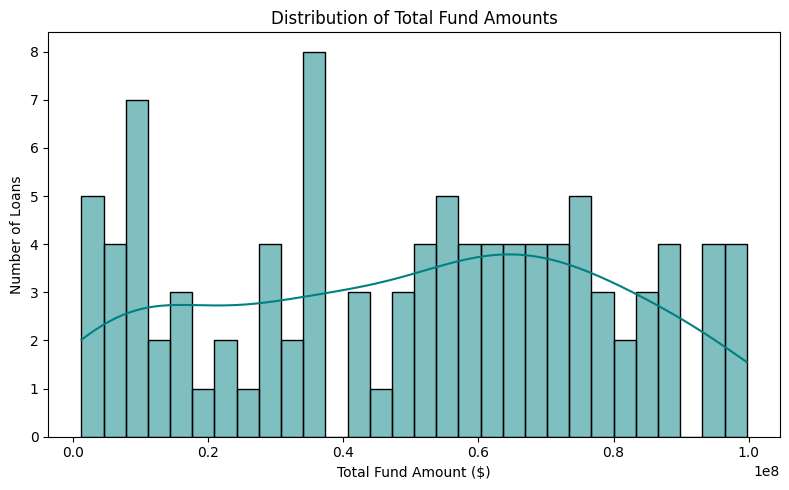

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

loan_df = pd.read_csv("loan_details_preprocessed.csv")

plt.figure(figsize=(8,5))
sns.histplot(loan_df['total_fund_amount'], bins=30, kde=True, color='teal')
plt.title("Distribution of Total Fund Amounts")
plt.xlabel("Total Fund Amount ($)")
plt.ylabel("Number of Loans")
plt.tight_layout()
plt.show()

The majority of loans are in the moderate range and linked to smaller business purchase values. This shows that SBA programs are effectively supporting small enterprises rather than large corporations.

**Equity Injection vs Total Fund Amount**

Description:
Shows the relationship between borrower investment and loan funding.
Reveals whether higher equity injection leads to higher approved loan amounts.

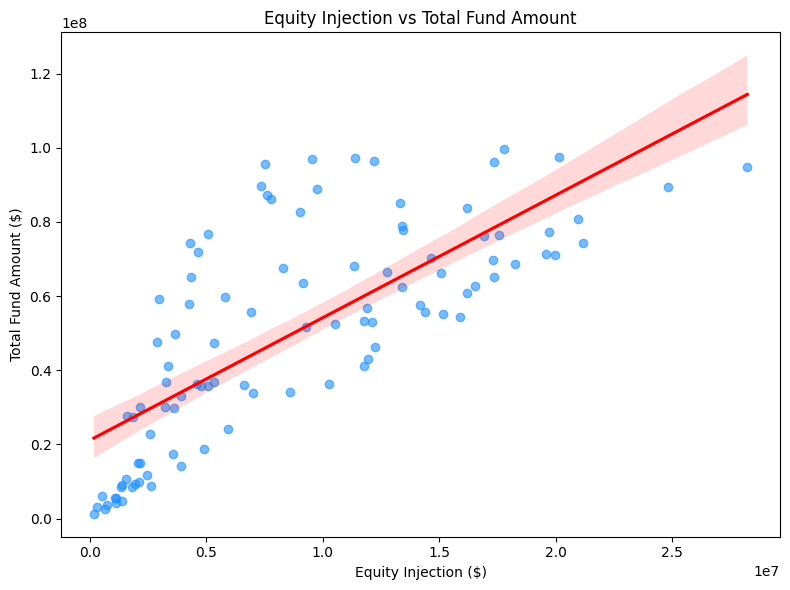

In [ ]:
plt.figure(figsize=(8,6))
sns.regplot(
    data=loan_df,
    x='equity_injection',
    y='total_fund_amount',
    scatter_kws={'alpha':0.6, 'color':'dodgerblue'},
    line_kws={'color':'red'}
)
plt.title("Equity Injection vs Total Fund Amount")
plt.xlabel("Equity Injection ($)")
plt.ylabel("Total Fund Amount ($)")
plt.tight_layout()
plt.show()

A clear positive linear trend emerges — as borrower equity increases, total fund amounts also rise.
This reflects lenders’ confidence: higher borrower investment likely results in larger approved loans, emphasizing shared risk and financial stability. Businesses investing their own money tend to get higher funding. When owners put in more equity, lenders are more confident — and as a result, the total loan amount they receive is often larger. It reflects mutual trust and commitment between the borrower and lender.

**Collateral Impact on Loan Amount**

Description:
Compares loan sizes for loans with and without collateral.
Shows if secured loans tend to have higher funding amounts.

/tmp/ipython-input-3419102514.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=loan_df, x='is_providing_collateral', y='total_fund_amount', palette='Set2')


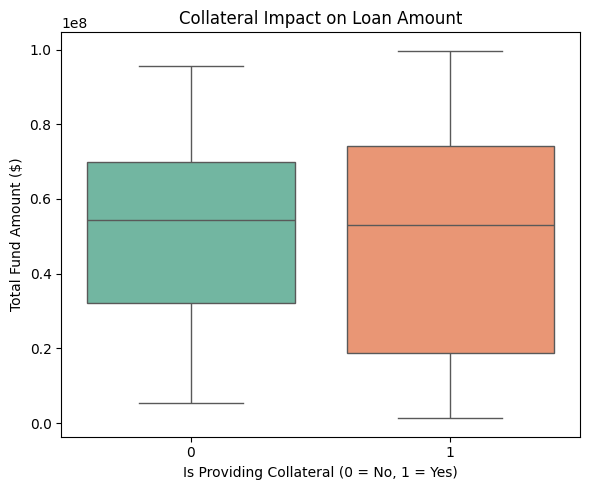

In [ ]:
plt.figure(figsize=(6,5))
sns.boxplot(data=loan_df, x='is_providing_collateral', y='total_fund_amount', palette='Set2')
plt.title("Collateral Impact on Loan Amount")
plt.xlabel("Is Providing Collateral (0 = No, 1 = Yes)")
plt.ylabel("Total Fund Amount ($)")
plt.tight_layout()
plt.show()

Loans backed by collateral generally show slightly higher median fund amounts, but variation exists across both groups.
This implies that while collateral adds assurance for lenders, it’s not the sole determinant of loan size — other factors like equity and business value matter too. Collateral helps, but isn’t everything.
While providing collateral can slightly increase the loan size, it’s not the only factor. Lenders also value business potential and owner involvement.

**Distribution of Business Purchase Prices**

Description:
Shows variation in the business purchase prices among borrowers.
Useful for understanding the financial scale of businesses applying for SBA loans.

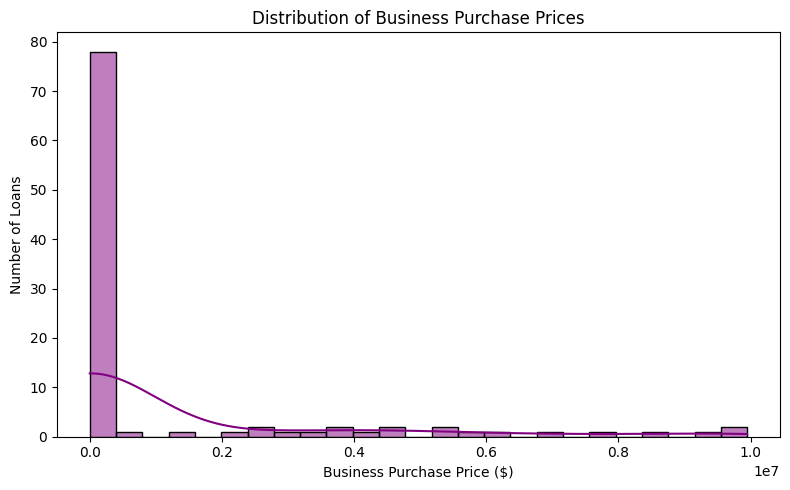

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(loan_df['business_purchase_price'], bins=25, kde=True, color='purple')
plt.title("Distribution of Business Purchase Prices")
plt.xlabel("Business Purchase Price ($)")
plt.ylabel("Number of Loans")
plt.tight_layout()
plt.show()

The vast majority of businesses fall within the lower price range (under $2M), with a sharp drop beyond that.
This heavy right-skew indicates most SBA loans are supporting small or mid-sized businesses, aligning with SBA’s core mission to empower SMEs.

**Correlation Heatmap**

Description:
Shows correlations between numeric fields like equity, purchase price, and total fund amount.
Helps identify which financial factors move together.

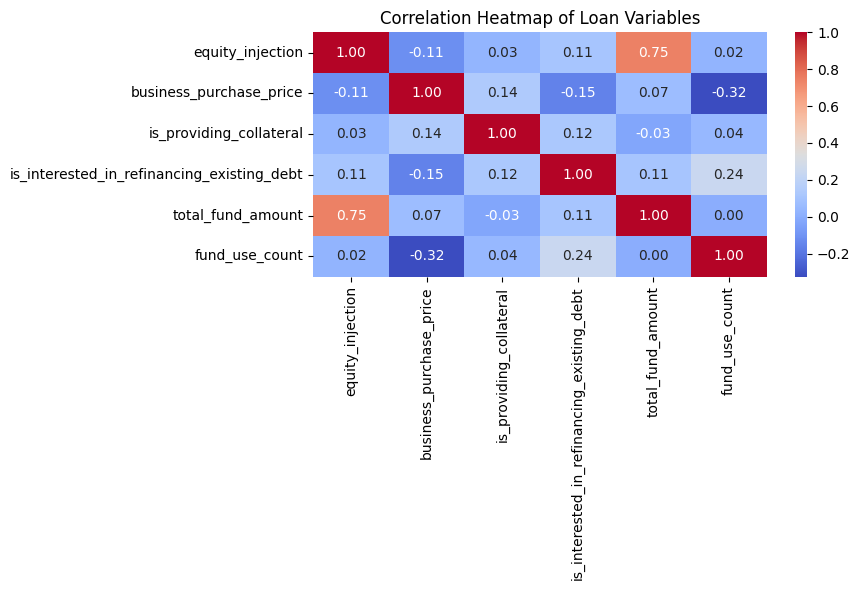

In [ ]:
plt.figure(figsize=(9,6))
num_df = loan_df.select_dtypes(include=['float64','int64'])
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Loan Variables")
plt.tight_layout()
plt.show()

The heatmap highlights a strong positive correlation (0.75) between equity injection and total fund amount.
Meanwhile, business purchase price and fund use count show weaker relationships, suggesting that loan value is more tied to borrower contribution than deal size.

**Top 10 Most Common Fund Uses**

Description:
Displays which loan purposes are most common across all inquiries.
Highlights the major business needs SBA loans are funding.

/tmp/ipython-input-2618957028.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Count', y='Fund Use', palette='viridis')


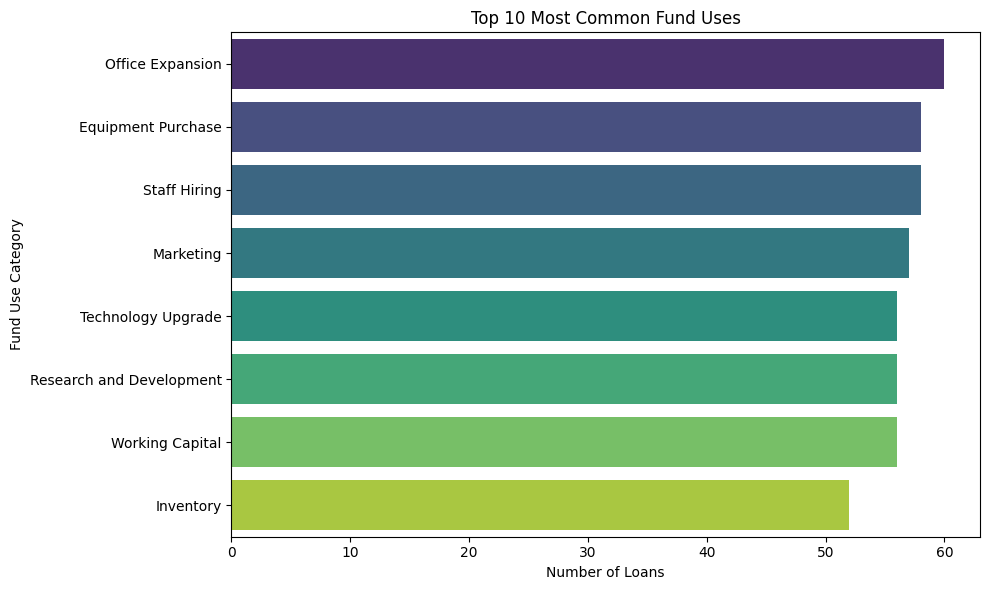

In [ ]:
fund_df = pd.read_csv("fund_uses_grouped.csv")
fund_df['fund_use_list'] = fund_df['fund_use_list'].apply(eval)
all_funds = [x for sub in fund_df['fund_use_list'] for x in sub]
from collections import Counter
fund_counts = Counter(all_funds)
top10 = pd.DataFrame(fund_counts.most_common(10), columns=['Fund Use', 'Count'])

plt.figure(figsize=(10,6))
sns.barplot(data=top10, x='Count', y='Fund Use', palette='viridis')
plt.title("Top 10 Most Common Fund Uses")
plt.xlabel("Number of Loans")
plt.ylabel("Fund Use Category")
plt.tight_layout()
plt.show()

Office Expansion, Equipment Purchase, and Staff Hiring dominate the top fund uses.
This suggests SBA-backed loans are primarily geared toward business growth, modernization, and capacity building — not just maintenance.

**Total Fund Amount by Category**

Description:
Aggregates total disbursed amount for each fund category.
Reveals which purposes get the most financial allocation.

/tmp/ipython-input-877207668.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sum.values, y=category_sum.index, palette='coolwarm')


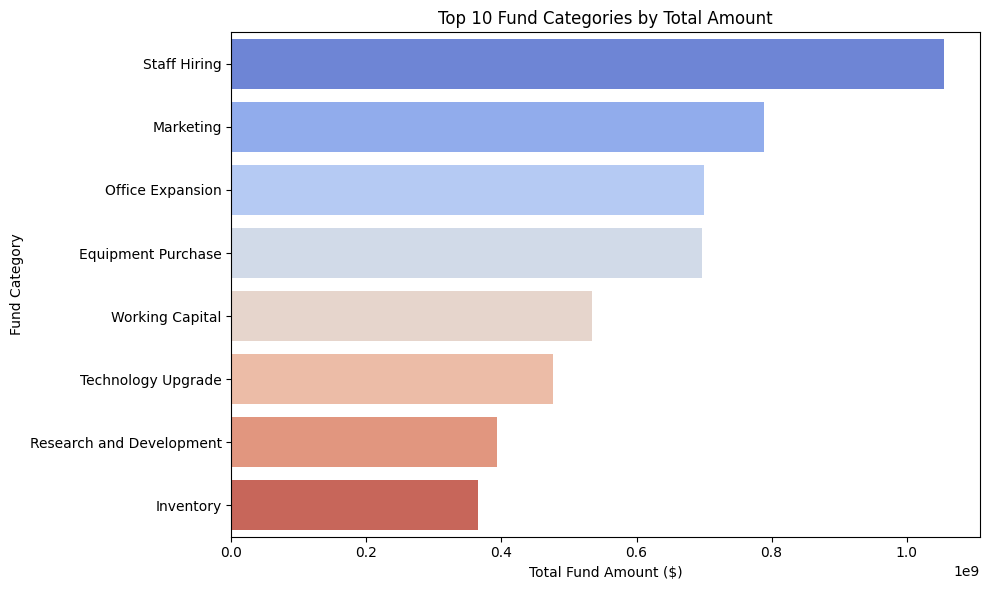

In [ ]:
fund_df['fund_amount_list'] = fund_df['fund_amount_list'].apply(eval)
exploded = fund_df.explode(['fund_use_list', 'fund_amount_list'])
category_sum = exploded.groupby('fund_use_list')['fund_amount_list'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=category_sum.values, y=category_sum.index, palette='coolwarm')
plt.title("Top 10 Fund Categories by Total Amount")
plt.xlabel("Total Fund Amount ($)")
plt.ylabel("Fund Category")
plt.tight_layout()
plt.show()

While “Staff Hiring” tops by total funding, Marketing and Office Expansion also receive large portions of total loan disbursement.
This indicates a strong focus on scaling workforce and market reach — crucial for post-loan growth impact.

**Fund Use Diversification (Number of Uses per Loan)**

Description:
Shows how diversified each loan is in terms of fund utilization.
Indicates whether borrowers use SBA funds for multiple purposes.

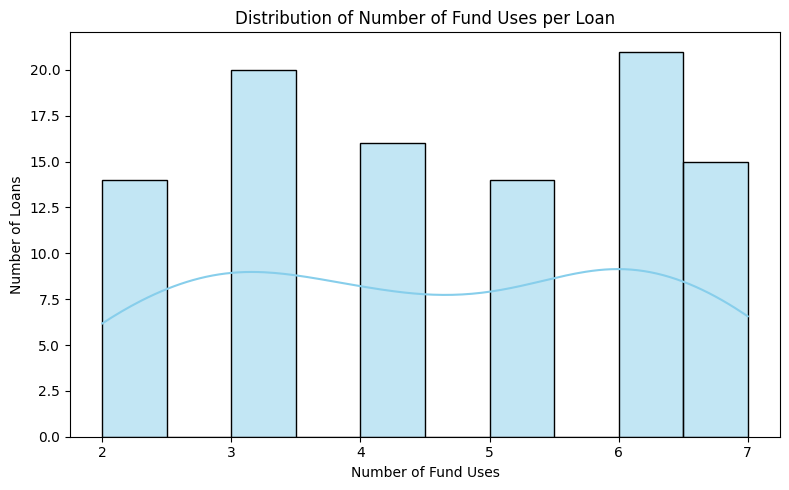

In [ ]:
fund_df['fund_count'] = fund_df['fund_use_list'].apply(len)
plt.figure(figsize=(8,5))
sns.histplot(fund_df['fund_count'], bins=10, kde=True, color='skyblue')
plt.title("Distribution of Number of Fund Uses per Loan")
plt.xlabel("Number of Fund Uses")
plt.ylabel("Number of Loans")
plt.tight_layout()
plt.show()

Most loans are diversified across 3–6 fund uses, showing a balanced utilization strategy.
This diversity highlights that SBA loans are often multi-purpose — used simultaneously for expansion, equipment, and working capital.

In [ ]:
import pandas as pd

# Load datasets
loan_original = pd.read_csv("loan_details.csv")
loan_cleaned = pd.read_csv("loan_details_preprocessed.csv")
fund_grouped = pd.read_csv("fund_uses_grouped.csv")

datasets = {
    "Original Loan Details": loan_original,
    "Preprocessed Loan Details": loan_cleaned,
    "Fund Uses Grouped": fund_grouped
}

# Summary function
def summarize(df, name):
    print(f"\n {name}")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\nColumn Data Types:")
    print(df.dtypes)
    print("\nMissing Values per Column:")
    print(df.isnull().sum())
    print("-" * 60)

# Generate summaries
for name, df in datasets.items():
    summarize(df, name)


 Original Loan Details
Rows: 100, Columns: 15

Column Data Types:
fund_uses                                      object
inquiry_id                                     object
user_id                                        object
organization_id                                object
id                                             object
meta_status                                    object
created_at                                     object
updated_at                                    float64
no_other_use_of_funds                          object
equity_injection                                int64
business_purchase_price                       float64
is_providing_collateral                        object
is_interested_in_refinancing_existing_debt     object
type_of_acquisition                            object
reason_for_acquisition                         object
dtype: object

Missing Values per Column:
fund_uses                                       0
inquiry_id                     

In [2]:
!pip install googletrans

# **NEW FILES**

In [18]:
import pandas as pd
import ast

# === STEP 1: Load file ===
df = pd.read_csv("loan_details.csv")

# === STEP 2: Parse fund_uses JSON ===
def parse_fund_uses(x):
    if pd.isna(x) or not isinstance(x, str) or not x.strip().startswith("["):
        return [], []
    try:
        data = ast.literal_eval(x)
        uses, amounts = [], []
        for item in data:
            if isinstance(item, dict):
                use = item.get("name") or item.get("fund_use_type") or item.get("type") or item.get("use")
                amount = item.get("amount") or item.get("fund_amount") or 0
                uses.append(use)
                amounts.append(float(amount))
        return [uses, amounts]
    except Exception:
        return [[], []]

parsed_results = df["fund_uses"].apply(parse_fund_uses)
df["fund_use_list"] = parsed_results.apply(lambda x: x[0])
df["fund_amount_list"] = parsed_results.apply(lambda x: x[1])

print("✅ fund_use_list and fund_amount_list created successfully!")

# === STEP 3: Group fund uses ===
fund_uses_grouped = (
    df.groupby("inquiry_id", as_index=False)
      .agg({
          "fund_use_list": lambda x: sum(x, []),
          "fund_amount_list": lambda x: sum(x, [])
      })
)

fund_uses_grouped["fund_use_count"] = fund_uses_grouped["fund_use_list"].apply(len)
fund_uses_grouped["total_fund_amount"] = fund_uses_grouped["fund_amount_list"].apply(lambda x: sum(x) if x else 0)

print("✅ fund_uses_grouped created successfully!")

# === STEP 4: Drop duplicate fund_use columns before merge ===
df_clean = df.drop(columns=["fund_use_list", "fund_amount_list"], errors="ignore")

# === STEP 5: Merge ===
merged = (
    df_clean.drop_duplicates(subset=["inquiry_id"])
    .merge(fund_uses_grouped, on="inquiry_id", how="left", validate="1:1")
)

# === STEP 6: Clean booleans ===
def bool_to_int(x):
    return 1 if str(x).lower() in ["t", "true", "1"] else 0

merged["is_providing_collateral"] = merged["is_providing_collateral"].apply(bool_to_int)
merged["business_purchase_price"] = merged["business_purchase_price"].fillna(0.0)
merged["equity_injection"] = merged["equity_injection"].fillna(0).astype(int)

# === STEP 7: Refinancing flag ===
def has_refinance(fund_uses):
    if isinstance(fund_uses, list):
        return int(any("refinance" in str(u).lower() for u in fund_uses))
    return 0

# (Now we know the merged column exists)
merged["is_interested_in_refinancing_existing_debt"] = merged["fund_use_list"].apply(has_refinance)

# === STEP 8: Select final schema ===
final_cols = [
    "inquiry_id",
    "equity_injection",
    "business_purchase_price",
    "is_providing_collateral",
    "is_interested_in_refinancing_existing_debt",
    "total_fund_amount",
    "fund_use_count",
    "fund_use_list",
    "fund_amount_list"
]

loan_details_preprocessed = merged[final_cols]

# === STEP 9: Save outputs ===
fund_uses_grouped.to_csv("fund_uses_grouped.csv", index=False)
loan_details_preprocessed.to_csv("loan_details_preprocessed.csv", index=False)

print("\n✅ Transformation complete!")
print("Generated files:")
print(" - fund_uses_grouped.csv")
print(" - loan_details_preprocessed.csv")
print("\nSample of final preprocessed data:")
print(loan_details_preprocessed.head(3))

✅ fund_use_list and fund_amount_list created successfully!
✅ fund_uses_grouped created successfully!

✅ Transformation complete!
Generated files:
 - fund_uses_grouped.csv
 - loan_details_preprocessed.csv

Sample of final preprocessed data:
                             inquiry_id  equity_injection  \
0  987cd4c4-130d-410c-a63d-406af4799a02           4126808   
1  4003f4e9-3348-4c4a-a4a3-02b1db46441e          19373108   
2  6da42ae5-917e-4e1e-b517-d908512bf970          23468320   

   business_purchase_price  is_providing_collateral  \
0                      0.0                        1   
1                      0.0                        1   
2                      0.0                        0   

   is_interested_in_refinancing_existing_debt  total_fund_amount  \
0                                           0         58364411.0   
1                                           0         70164366.0   
2                                           0         84978360.0   

   fund_use_count    